Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)



Training and evaluating models...
Model: SVM, Accuracy: 0.9267, F1 Score: 0.9282
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84        48
           1       0.89      0.91      0.90        55
           2       0.89      0.95      0.92        44
           3       0.92      0.85      0.88        39
           4       0.95      1.00      0.98        41
           5       0.94      0.96      0.95        50
           6       0.95      0.98      0.96        42
           7       0.95      0.91      0.93        45
           8       1.00      0.97      0.99        38
           9       0.94      0.92      0.93        48

    accuracy                           0.93       450
   macro avg       0.93      0.93      0.93       450
weighted avg       0.93      0.93      0.93       450

Model: GMM, Accuracy: 0.1711, F1 Score: 0.1507
Classification Report:
               precision    recall  f1-score   support

         

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: SVM, Accuracy: 0.9200, F1 Score: 0.9189
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.80      0.79        41
           1       0.90      0.88      0.89        40
           2       0.86      0.93      0.89        40
           3       0.85      0.77      0.81        52
           4       1.00      0.97      0.98        59
           5       0.95      0.97      0.96        39
           6       0.95      1.00      0.98        42
           7       1.00      0.97      0.99        38
           8       0.96      0.98      0.97        50
           9       0.94      0.94      0.94        49

    accuracy                           0.92       450
   macro avg       0.92      0.92      0.92       450
weighted avg       0.92      0.92      0.92       450

Model: GMM, Accuracy: 0.0667, F1 Score: 0.0770
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00 

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


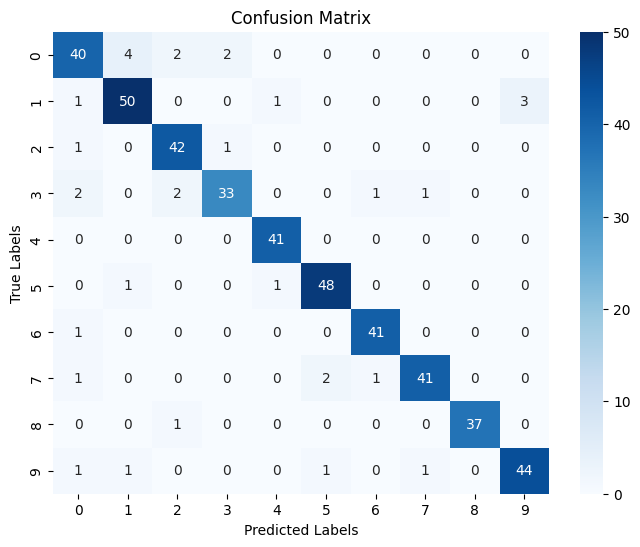


Confusion Matrix for SVM on Denoised Audio:


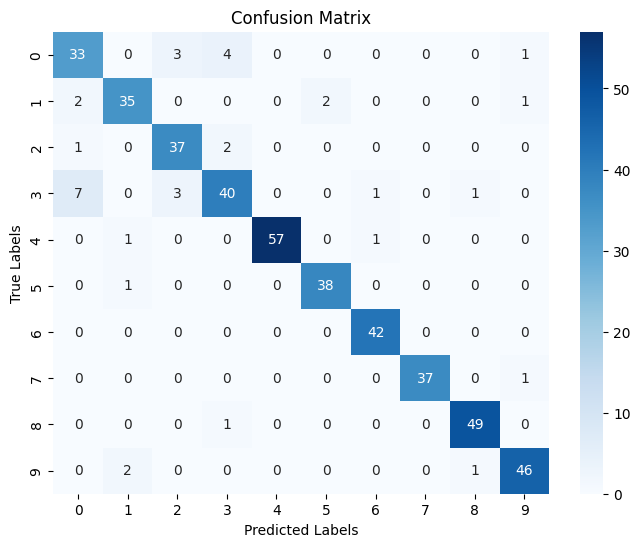


Correlation Matrix for Original Audio Features:


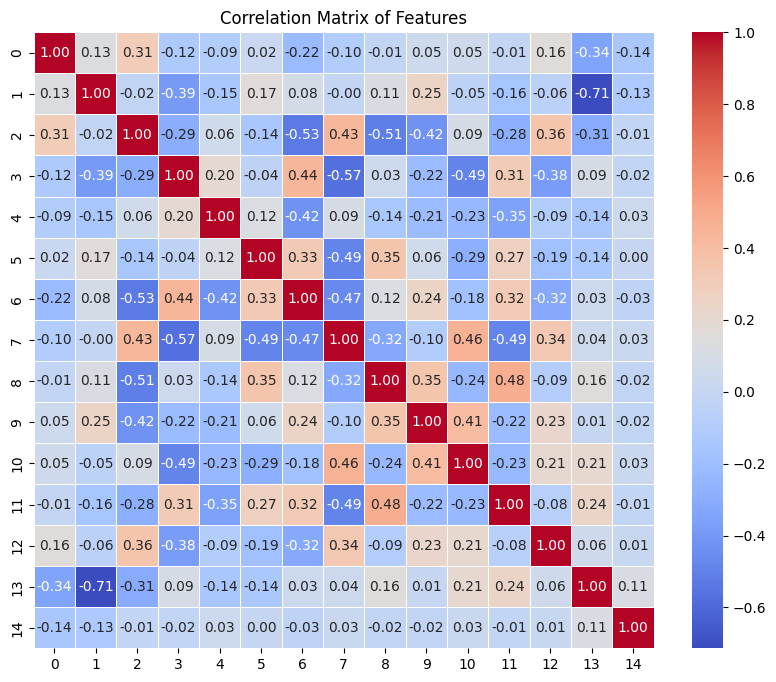


Correlation Matrix for Denoised Audio Features:


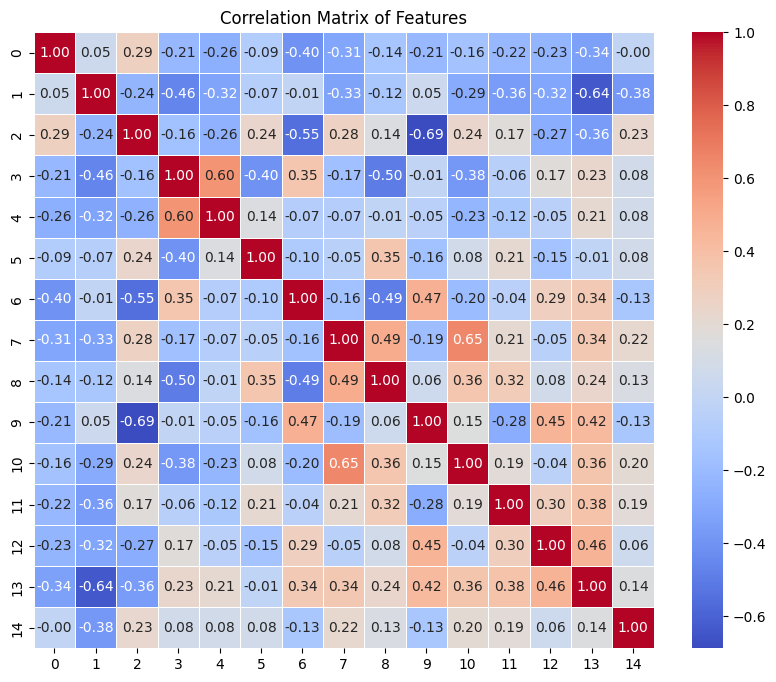


Cross-validation for SVM on Original Audio:
SVM Cross-validation Accuracy (Original): 0.8673

Plotting Cross-validation Accuracy for SVM on Original Audio:


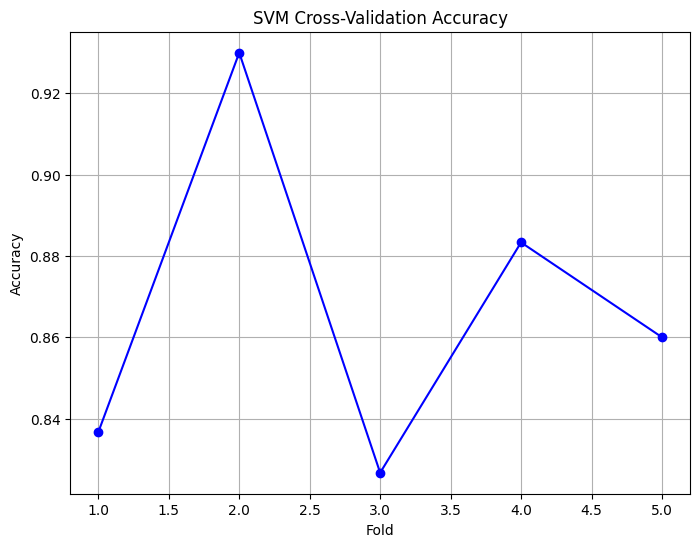

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from scipy.stats import ttest_ind

# Feature extraction function
def extract_features(audio, sr, n_mfcc=13):
    n_fft = int(sr * 0.02)
    hop_length = int(sr * 0.01)

    # MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    mfccs_mean = np.mean(mfccs.T, axis=0)

    # Zero Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=audio, hop_length=hop_length))

    # Fundamental Frequency (F0) and Jitter
    f0, _, _ = librosa.pyin(audio, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), sr=sr)
    f0_valid = f0[~np.isnan(f0)]
    jitter = np.std(np.diff(f0_valid)) if f0_valid.size > 1 else 0

    # Combine features
    return np.concatenate([mfccs_mean, [zcr, jitter]])

# Load dataset and extract features
def preprocess_data(data_folder):
    features, labels = [], []
    for file in os.listdir(data_folder):
        if file.endswith('.wav'):
            label = int(file.split('_')[0])
            filepath = os.path.join(data_folder, file)
            audio, sr = librosa.load(filepath, sr=16000)
            feature = extract_features(audio, sr)
            features.append(feature)
            labels.append(label)
    return np.array(features), np.array(labels)

# Train and evaluate model
def train_model(X_train, X_test, y_train, y_test, model_type='SVM', apply_pca=False, normalize=True):
    if normalize:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    if apply_pca:
        pca = PCA(n_components=0.95)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
        print(f"PCA reduced features to {pca.n_components_} dimensions.")

    if model_type == 'SVM':
        model = SVC(kernel='linear', random_state=42)
    elif model_type == 'GMM':
        model = GaussianMixture(n_components=len(np.unique(y_train)), random_state=42)
    else:
        raise ValueError("Unsupported model type. Choose 'SVM' or 'GMM'.")

    if model_type == 'SVM':
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    elif model_type == 'GMM':
        model.fit(X_train)
        y_pred = model.predict(X_test)

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"Model: {model_type}, Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    return model, acc, f1, y_test, y_pred

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Plot correlation matrix
def plot_correlation_matrix(X):
    corr_matrix = np.corrcoef(X, rowvar=False)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix of Features')
    plt.show()

# Perform statistical tests
def perform_stat_tests(f1_scores):
    t_stat, p_val = ttest_ind(f1_scores['Original_SVM'], f1_scores['Denoised_SVM'], equal_var=False)
    print(f"T-Test between SVM on Original vs Denoised: t-stat={t_stat:.4f}, p-value={p_val:.4f}")

    t_stat, p_val = ttest_ind(f1_scores['Original_GMM'], f1_scores['Denoised_GMM'], equal_var=False)
    print(f"T-Test between GMM on Original vs Denoised: t-stat={t_stat:.4f}, p-value={p_val:.4f}")

    return t_stat, p_val

# Plot Cross-Validation Accuracy
def plot_cross_val_accuracy(X, y, model_type='SVM'):
    if model_type == 'SVM':
        model = SVC(kernel='linear', random_state=42)
    elif model_type == 'GMM':
        model = GaussianMixture(n_components=len(np.unique(y)), random_state=42)
    else:
        raise ValueError("Unsupported model type. Choose 'SVM' or 'GMM'.")

    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, 6), cv_scores, marker='o', linestyle='-', color='b', label='Accuracy')
    plt.title(f'{model_type} Cross-Validation Accuracy')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

# Main function
def main(original_folder, denoised_folder):
    # Process original and denoised folders
    original_X, original_y = preprocess_data(original_folder)
    denoised_X, denoised_y = preprocess_data(denoised_folder)

    # Split into train/test sets
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(original_X, original_y, test_size=0.3, random_state=42)
    X_train_denoised, X_test_denoised, y_train_denoised, y_test_denoised = train_test_split(denoised_X, denoised_y, test_size=0.3, random_state=42)

    # Store F1 scores for statistical test
    f1_scores = {
        'Original_SVM': [], 'Original_GMM': [],
        'Denoised_SVM': [], 'Denoised_GMM': []
    }

    # Train and evaluate models
    print("\nTraining and evaluating models...")

    # Train SVM on original audio
    _, _, f1_svm_orig, y_test_orig, y_pred_orig = train_model(X_train_orig, X_test_orig, y_train_orig, y_test_orig, model_type='SVM', apply_pca=False)
    f1_scores['Original_SVM'].append(f1_svm_orig)

    # Train GMM on original audio
    _, _, f1_gmm_orig, _, _ = train_model(X_train_orig, X_test_orig, y_train_orig, y_test_orig, model_type='GMM', apply_pca=False)
    f1_scores['Original_GMM'].append(f1_gmm_orig)

    # Train SVM on denoised audio
    _, _, f1_svm_denoised, y_test_denoised, y_pred_denoised = train_model(X_train_denoised, X_test_denoised, y_train_denoised, y_test_denoised, model_type='SVM', apply_pca=False)
    f1_scores['Denoised_SVM'].append(f1_svm_denoised)

    # Train GMM on denoised audio
    _, _, f1_gmm_denoised, _, _ = train_model(X_train_denoised, X_test_denoised, y_train_denoised, y_test_denoised, model_type='GMM', apply_pca=False)
    f1_scores['Denoised_GMM'].append(f1_gmm_denoised)

    # Perform T-Test
    print("\nPerforming Statistical Comparison:")
    perform_stat_tests(f1_scores)

    # Plot confusion matrices
    print("\nConfusion Matrix for SVM on Original Audio:")
    plot_confusion_matrix(y_test_orig, y_pred_orig, labels=np.unique(original_y))

    print("\nConfusion Matrix for SVM on Denoised Audio:")
    plot_confusion_matrix(y_test_denoised, y_pred_denoised, labels=np.unique(denoised_y))

    # Plot Correlation Matrix
    print("\nCorrelation Matrix for Original Audio Features:")
    plot_correlation_matrix(original_X)

    print("\nCorrelation Matrix for Denoised Audio Features:")
    plot_correlation_matrix(denoised_X)

    # Cross-validation for SVM on Original Audio
    print("\nCross-validation for SVM on Original Audio:")
    svm_cross_val = cross_val_score(SVC(kernel='linear', random_state=42), original_X, original_y, cv=5)
    print(f"SVM Cross-validation Accuracy (Original): {np.mean(svm_cross_val):.4f}")

    # Plot Cross-validation for SVM
    print("\nPlotting Cross-validation Accuracy for SVM on Original Audio:")
    plot_cross_val_accuracy(original_X, original_y, model_type='SVM')

# Specify the paths to the original and denoised folders
from google.colab import drive
drive.mount('/content/drive')
original_folder = '/content/drive/My Drive/recordings'
denoised_folder = '/content/drive/My Drive/denois_recodings'
main(original_folder, denoised_folder)

